## Example 2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
np.set_printoptions(threshold=5)
np.__version__

'1.10.1'

In [4]:
import pystan
pystan.__version__

'2.8.0.0'

In [5]:
d = np.loadtxt('input/data-season.txt', skiprows=1)
d

array([ 18.073,  23.665,  16.41 , ...,  31.892,  20.276,  22.866])

In [6]:
T = len(d)
T_next = 8
data = dict(T=T, T_next=T_next, Y=d)

stanmodel = pystan.StanModel(file='model.stan')

In [7]:
fit = stanmodel.sampling(data=data, iter=10200, warmup=200, thin=10, chains=3, seed=123)
fit

Inference for Stan model: anon_model_656206facfcc638866cf547e2efcf34c.
3 chains, each with iter=10200; warmup=200; thin=10; 
post-warmup draws per chain=1000, total post-warmup draws=3000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       18.39    0.01   0.61   17.2  17.96   18.4  18.78  19.61 3000.0    1.0
mu[1]       18.52  8.6e-3   0.47  17.54  18.23   18.5  18.82  19.49 3000.0    1.0
mu[2]        18.5  8.6e-3   0.47  17.56   18.2  18.51  18.79  19.46 3000.0    1.0
mu[3]       17.56  8.1e-3   0.44  16.62  17.28  17.56  17.86  18.42 3000.0    1.0
mu[4]       17.17  7.7e-3   0.42  16.31   16.9  17.17  17.42  18.01 3000.0    1.0
mu[5]        16.8  7.6e-3   0.42  15.99  16.53   16.8  17.07  17.63 3000.0    1.0
mu[6]        16.2  7.9e-3   0.43  15.35  15.92  16.21  16.49  17.05 3000.0    1.0
mu[7]       16.26  7.9e-3   0.43  15.42  15.98  16.27  16.53  17.14 3000.0    1.0
mu[8]       15.79  7.7e-3   0.42  14.96  15.52  15.81  16.04  16.65 3000

In [8]:
# runstan-post-decition.R
la = fit.extract()
x_smp = la['y_next'][:, 0]
x_smp

array([ 22.39088753,  24.54193   ,  24.67199034, ...,  25.12861719,
        23.80344528,  25.15915594])

In [9]:
def loss_function(x):
    return np.sum(np.where(x < x_smp, 2 * (x_smp - x), 1 - np.exp(-(x - x_smp))))

import scipy.optimize as optimize
y_decision = optimize.minimize_scalar(loss_function, method='brent', bracket=(5, 50))
y_decision.x

26.272423324182942

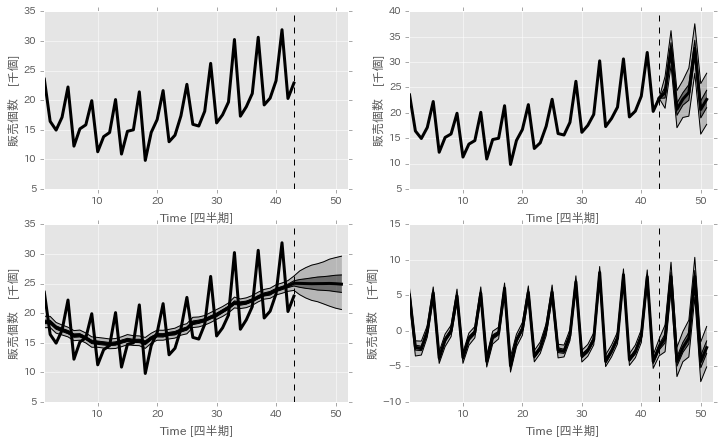

In [10]:
# runstan-post-fig2.R

# after estimation
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes[0, 0].plot(np.arange(T), d, color='black', linewidth=3)

def tsplot(ax, x, y_smp, obs=True):
    qua = np.percentile(y_smp, q=[2.5, 25, 50, 75, 97.5], axis=0)
    ax.plot(x, qua[2, :], color='black', linewidth=3)
    ax.fill_between(x, qua[1, :], qua[3, :], color='black', alpha=0.4)
    ax.fill_between(x, qua[0, :], qua[4, :], color='black', alpha=0.2)
    for i in [0, 1, 3, 4]:
        ax.plot(x, qua[i, :], color='black')
    if obs:
        ax.plot(np.arange(T), d, color='black', linewidth=3)

# 最後の観測値を追加
last = np.repeat(d[-1], len(la['y_next'])).reshape(3000, 1)
y_next = np.hstack([last, la['y_next']])

tsplot(axes[0, 1], np.arange(T - 1, T + T_next), y_next)
tsplot(axes[1, 0], np.arange(T + T_next), la['mu_all'])
tsplot(axes[1, 1], np.arange(T + T_next), la['s_all'], obs=False)

for ax in axes.flatten():
    ax.axvline(T - 1, color='black', linestyle='dashed')
    ax.set_xlim(0.9, 52.1)
    ax.set_xlabel(u'Time [四半期]')
    ax.set_ylabel(u'販売個数　[千個]')